In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from dataset import Dataset, to_device
from model import ResNet28
from time import time
from tqdm.notebook import tqdm
import json

# Model Saving/Loading Methods

In [3]:
def load_model_only(config):
    path = config.get('model_path', '')
    f = f"{path}/{config['model_identifier']}.pth"
    print("Loading existing model")
    checkpoint = torch.load(f)
    net = checkpoint['net']
    mean_losses = checkpoint['mean_losses']
    return net, mean_losses

def init_h1_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0.01)
        
def load_model_with_config(config, X_train=None, model_width=None, force_train=False):
    # a bit hacky, but in the training phase, we never load and use the minmax scalers
    # just putting it here for when we want to load the model elsewhere THEN revert scaling
    # probably better to have the scalers saved separately....
    device = config.get('device','cpu')
    pyt_device = torch.device(device)
    
    path = config.get('model_path', '')
    f = f"{path}/{config['model_identifier']}.pth"
    
    if os.path.exists(f) and not force_train:
        print("Loading existing model")
        checkpoint = torch.load(f)
        net = checkpoint['net']
        next_epoch = checkpoint['next_epoch']
        loss_func = checkpoint['loss_func']
        optimizer = checkpoint['optimizer']
        scaler = checkpoint['scaler']
        mean_losses = checkpoint['mean_losses']
    else:
        if X_train is None:
            raise Exception('Cannot create model without X_train')
        print("New model created")
        net = ResNet28(input_size=model_width[0], output_size=model_width[1], width=config['model_width'])
        net.apply(init_h1_weights)
        pos_weight = to_device(torch.tensor([config['loss'].get('pos_weight',1)]), pyt_device) # increase/decrease precision
        loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        opt_config=config['optimizer']
        optimizer = torch.optim.SGD(net.parameters(), lr=opt_config['lr'], momentum=opt_config['momentum'])
        scaler = StandardScaler().fit(X_train)
        mean_losses = []
        next_epoch = 0
        save_model_with_config(config, net=net, loss_func=loss_func, optimizer=optimizer,
                               scaler=scaler,
                               mean_losses=mean_losses, next_epoch=next_epoch,
                              )
        # blank scaler when creating new model
    return net, loss_func, optimizer, scaler, mean_losses, next_epoch

def save_model_with_config(config, **kwargs):
    path = config.get('model_path', '')

    f = f"{path}/{config['model_identifier']}.pth"
    torch.save(kwargs, f)

# Custom Scaler

In [138]:
values = ['atr', 'atr_12', 'atr_diff', 'atr_diff_12', 'atr_ma14', 'atr_ma14_12']
for v in values:
    if re.match('atr$|atr_[0-9]+|atr_ma[0-9]+',v):
        print(v)


atr
atr_12
atr_ma14
atr_ma14_12


In [176]:
np.finfo(float).tiny

2.2250738585072014e-308

In [190]:
from sklearn.preprocessing import StandardScaler
import re

class ModelScaler():
    standard_scaler = None
    fit = False
    stdcols = ['number_of_trades','volume','quote_asset_volume',
               'taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
               #'rsi_diff', 'atr_diff'
              ]
    tostd = []
    atr_max = 0
    atr_diff_std = 0
    rsi_diff_std = 0
    
    min_max_range=(-1, 1)
    
    def __init__(self):
        self.standard_scaler = StandardScaler()
        
    def fit(self, X):
        for c in self.stdcols:
            for v in X.columns:
                if v.startswith(c):
                    self.tostd.append(v)
                
        if len(self.tostd) > 0:
            self.standard_scaler.fit(X[self.tostd])
            
        if 'atr' in X.columns:
            self.atr_max = X['atr'].max()
        if 'atr_diff' in X.columns:
            self.atr_diff_std = X['atr_diff'].std()
        if 'rsi_diff' in X.columns:
            self.rsi_diff_std = X['rsi_diff'].std()
            
        self.fit = True
        
    def transform(self, X_in):
        if self.fit == True:
            X = X_in.copy()
            open_price = X['open'].copy()
            stddev = (((X['close'] - X['open'])**2 + \
                       (X['high'] - X['open'])**2 + \
                       (X['low'] - X['open'])**2) / 3)**0.5 + np.finfo(float).tiny
            
            for c in X.columns:
                if c in ['open','high','low','close'] or \
                   re.match('open_[0-9]+', c) or \
                   re.match('high_[0-9]+', c) or \
                   re.match('low_[0-9]+', c) or \
                   re.match('close_[0-9]+', c) or \
                   re.match('sup[0-9]+', c) or \
                   re.match('res[0-9]+', c) or \
                   re.match('ma[0-9]+', c):
                    X[c] = (X[c]-open_price)/stddev
                elif c.startswith('atr_diff') and self.atr_diff_std>0:
                    X[c] = X[c]/self.atr_diff_std
                elif re.match('atr$|atr_[0-9]+|atr_ma[0-9]+',c):
                    X[c] = X[c]/self.atr_max
                elif c.startswith('rsi_diff') and self.rsi_diff_std>0:
                    X[c] = X[c]/self.rsi_diff_std
                elif re.match('rsi$|rsi_[0-9]+|rsi_ma[0-9]+',c):
                    X[c] = (X[c]-50)/20 # thus -1/1 will be at 30/70 threshold
            
            if 'dow' in X.columns:
                X['dow'] = X['dow'] / 6
                
            if len(self.tostd) > 0:
                X[self.tostd] = self.standard_scaler.transform(X[self.tostd])
            return X
        else:
            raise Exception('ModelScaler not yet fit')
            
    def fit_transform(self, X_in):
        self.fit(X_in)
        return self.transform(X_in)

In [191]:
pd.set_option('max_columns',500)
scaler = ModelScaler()
X_new = scaler.fit_transform(X_train)
# X_new = scaler.fit_transform(X_train[['open','high','low','close','number_of_trades', 'ma14']])
X_new

,open,high,low,close,dow,tod,number_of_trades,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ma14,ma30,ma90,sup14,sup30,sup90,res14,res30,res90,atr,atr_diff,atr_ma14,rsi,rsi_diff,rsi_ma14,trend_up,trend_up3,trend_up14,trend_up30,cs_ss,cs_ssr,cs_hm,cs_hmr,cs_brh,cs_buh,cs_ebu,cs_ebr,open_1,open_2,open_3,open_4,open_5,open_6,open_7,open_8,open_9,open_10,open_11,open_12,open_13,open_14,high_1,high_2,high_3,high_4,high_5,high_6,high_7,high_8,high_9,high_10,high_11,high_12,high_13,high_14,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10,low_11,low_12,low_13,low_14,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,number_of_trades_1,number_of_trades_2,number_of_trades_3,number_of_trades_4,number_of_trades_5,number_of_trades_6,number_of_trades_7,number_of_trades_8,number_of_trades_9,number_of_trades_10,number_of_trades_11,number_of_trades_12,number_of_trades_13,number_of_trades_14,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,volume_14,quote_asset_volume_1,quote_asset_volume_2,quote_asset_volume_3,quote_asset_volume_4,quote_asset_volume_5,quote_asset_volume_6,quote_asset_volume_7,quote_asset_volume_8,quote_asset_volume_9,quote_asset_volume_10,quote_asset_volume_11,quote_asset_volume_12,quote_asset_volume_13,quote_asset_volume_14,taker_buy_base_asset_volume_1,taker_buy_base_asset_volume_2,taker_buy_base_asset_volume_3,taker_buy_base_asset_volume_4,taker_buy_base_asset_volume_5,taker_buy_base_asset_volume_6,taker_buy_base_asset_volume_7,taker_buy_base_asset_volume_8,taker_buy_base_asset_volume_9,taker_buy_base_asset_volume_10,taker_buy_base_asset_volume_11,taker_buy_base_asset_volume_12,taker_buy_base_asset_volume_13,taker_buy_base_asset_volume_14,taker_buy_quote_asset_volume_1,taker_buy_quote_asset_volume_2,taker_buy_quote_asset_volume_3,taker_buy_quote_asset_volume_4,taker_buy_quote_asset_volume_5,taker_buy_quote_asset_volume_6,taker_buy_quote_asset_volume_7,taker_buy_quote_asset_volume_8,taker_buy_quote_asset_volume_9,taker_buy_quote_asset_volume_10,taker_buy_quote_asset_volume_11,taker_buy_quote_asset_volume_12,taker_buy_quote_asset_volume_13,taker_buy_quote_asset_volume_14,ma14_1,ma14_2,ma14_3,ma14_4,ma14_5,ma14_6,ma14_7,ma14_8,ma14_9,ma14_10,ma14_11,ma14_12,ma14_13,ma14_14,ma30_1,ma30_2,ma30_3,ma30_4,ma30_5,ma30_6,ma30_7,ma30_8,ma30_9,ma30_10,ma30_11,ma30_12,ma30_13,ma30_14,ma90_1,ma90_2,ma90_3,ma90_4,ma90_5,ma90_6,ma90_7,ma90_8,ma90_9,ma90_10,ma90_11,ma90_12,ma90_13,ma90_14,sup14_1,sup14_2,sup14_3,sup14_4,sup14_5,sup14_6,sup14_7,sup14_8,sup14_9,sup14_10,sup14_11,sup14_12,sup14_13,sup14_14,sup30_1,sup30_2,sup30_3,sup30_4,sup30_5,sup30_6,sup30_7,sup30_8,sup30_9,sup30_10,sup30_11,sup30_12,sup30_13,sup30_14,sup90_1,sup90_2,sup90_3,sup90_4,sup90_5,sup90_6,sup90_7,sup90_8,sup90_9,sup90_10,sup90_11,sup90_12,sup90_13,sup90_14,res14_1,res14_2,...,atr_3,atr_4,atr_5,atr_6,atr_7,atr_8,atr_9,atr_10,atr_11,atr_12,atr_13,atr_14,atr_diff_1,atr_diff_2,atr_diff_3,atr_diff_4,atr_diff_5,atr_diff_6,atr_diff_7,atr_diff_8,atr_diff_9,atr_diff_10,atr_diff_11,atr_diff_12,atr_diff_13,atr_diff_14,atr_ma14_1,atr_ma14_2,atr_ma14_3,atr_ma14_4,atr_ma14_5,atr_ma14_6,atr_ma14_7,atr_ma14_8,atr_ma14_9,atr_ma14_10,atr_ma14_11,atr_ma14_12,atr_ma14_13,atr_ma14_14,rsi_1,rsi_2,rsi_3,rsi_4,rsi_5,rsi_6,rsi_7,rsi_8,rsi_9,rsi_10,rsi_11,rsi_12,rsi_13,rsi_14,rsi_diff_1,rsi_diff_2,rsi_diff_3,rsi_diff_4,rsi_diff_5,rsi_diff_6,rsi_diff_7,rsi_diff_8,rsi_diff_9,rsi_diff_10,rsi_diff_11,rsi_diff_12,rsi_diff_13,rsi_diff_14,rsi_ma14_1,rsi_ma14_2,rsi_ma14_3,rsi_ma14_4,rsi_ma14_5,rsi_ma14_6,rsi_ma14_7,rsi_ma14_8,rsi_ma14_9,rsi_ma14_10,rsi_ma14_11,rsi_ma14_12,rsi_ma14_13,rsi_ma14_14,trend_up_1,trend_up_2,trend_up_3,trend_up_4,trend_up_5,trend_up_6,trend_up_7,trend_up_8,trend_up_9,trend_up_10,trend_up_11,trend_up_12,trend_up_13,trend_up_14,trend_up3_1,trend_up3_2,trend_up3_3,trend_up3_4,trend_up3_5,tre

In [182]:
X_new[X_new.ma14==np.inf]

,open,high,low,close,dow,tod,number_of_trades,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ma14,ma30,ma90,sup14,sup30,sup90,res14,res30,res90,atr,atr_diff,atr_ma14,rsi,rsi_diff,rsi_ma14,trend_up,trend_up3,trend_up14,trend_up30,cs_ss,cs_ssr,cs_hm,cs_hmr,cs_brh,cs_buh,cs_ebu,cs_ebr,open_1,open_2,open_3,open_4,open_5,open_6,open_7,open_8,open_9,open_10,open_11,open_12,open_13,open_14,high_1,high_2,high_3,high_4,high_5,high_6,high_7,high_8,high_9,high_10,high_11,high_12,high_13,high_14,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10,low_11,low_12,low_13,low_14,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,number_of_trades_1,number_of_trades_2,number_of_trades_3,number_of_trades_4,number_of_trades_5,number_of_trades_6,number_of_trades_7,number_of_trades_8,number_of_trades_9,number_of_trades_10,number_of_trades_11,number_of_trades_12,number_of_trades_13,number_of_trades_14,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,volume_14,quote_asset_volume_1,quote_asset_volume_2,quote_asset_volume_3,quote_asset_volume_4,quote_asset_volume_5,quote_asset_volume_6,quote_asset_volume_7,quote_asset_volume_8,quote_asset_volume_9,quote_asset_volume_10,quote_asset_volume_11,quote_asset_volume_12,quote_asset_volume_13,quote_asset_volume_14,taker_buy_base_asset_volume_1,taker_buy_base_asset_volume_2,taker_buy_base_asset_volume_3,taker_buy_base_asset_volume_4,taker_buy_base_asset_volume_5,taker_buy_base_asset_volume_6,taker_buy_base_asset_volume_7,taker_buy_base_asset_volume_8,taker_buy_base_asset_volume_9,taker_buy_base_asset_volume_10,taker_buy_base_asset_volume_11,taker_buy_base_asset_volume_12,taker_buy_base_asset_volume_13,taker_buy_base_asset_volume_14,taker_buy_quote_asset_volume_1,taker_buy_quote_asset_volume_2,taker_buy_quote_asset_volume_3,taker_buy_quote_asset_volume_4,taker_buy_quote_asset_volume_5,taker_buy_quote_asset_volume_6,taker_buy_quote_asset_volume_7,taker_buy_quote_asset_volume_8,taker_buy_quote_asset_volume_9,taker_buy_quote_asset_volume_10,taker_buy_quote_asset_volume_11,taker_buy_quote_asset_volume_12,taker_buy_quote_asset_volume_13,taker_buy_quote_asset_volume_14,ma14_1,ma14_2,ma14_3,ma14_4,ma14_5,ma14_6,ma14_7,ma14_8,ma14_9,ma14_10,ma14_11,ma14_12,ma14_13,ma14_14,ma30_1,ma30_2,ma30_3,ma30_4,ma30_5,ma30_6,ma30_7,ma30_8,ma30_9,ma30_10,ma30_11,ma30_12,ma30_13,ma30_14,ma90_1,ma90_2,ma90_3,ma90_4,ma90_5,ma90_6,ma90_7,ma90_8,ma90_9,ma90_10,ma90_11,ma90_12,ma90_13,ma90_14,sup14_1,sup14_2,sup14_3,sup14_4,sup14_5,sup14_6,sup14_7,sup14_8,sup14_9,sup14_10,sup14_11,sup14_12,sup14_13,sup14_14,sup30_1,sup30_2,sup30_3,sup30_4,sup30_5,sup30_6,sup30_7,sup30_8,sup30_9,sup30_10,sup30_11,sup30_12,sup30_13,sup30_14,sup90_1,sup90_2,sup90_3,sup90_4,sup90_5,sup90_6,sup90_7,sup90_8,sup90_9,sup90_10,sup90_11,sup90_12,sup90_13,sup90_14,res14_1,res14_2,...,atr_3,atr_4,atr_5,atr_6,atr_7,atr_8,atr_9,atr_10,atr_11,atr_12,atr_13,atr_14,atr_diff_1,atr_diff_2,atr_diff_3,atr_diff_4,atr_diff_5,atr_diff_6,atr_diff_7,atr_diff_8,atr_diff_9,atr_diff_10,atr_diff_11,atr_diff_12,atr_diff_13,atr_diff_14,atr_ma14_1,atr_ma14_2,atr_ma14_3,atr_ma14_4,atr_ma14_5,atr_ma14_6,atr_ma14_7,atr_ma14_8,atr_ma14_9,atr_ma14_10,atr_ma14_11,atr_ma14_12,atr_ma14_13,atr_ma14_14,rsi_1,rsi_2,rsi_3,rsi_4,rsi_5,rsi_6,rsi_7,rsi_8,rsi_9,rsi_10,rsi_11,rsi_12,rsi_13,rsi_14,rsi_diff_1,rsi_diff_2,rsi_diff_3,rsi_diff_4,rsi_diff_5,rsi_diff_6,rsi_diff_7,rsi_diff_8,rsi_diff_9,rsi_diff_10,rsi_diff_11,rsi_diff_12,rsi_diff_13,rsi_diff_14,rsi_ma14_1,rsi_ma14_2,rsi_ma14_3,rsi_ma14_4,rsi_ma14_5,rsi_ma14_6,rsi_ma14_7,rsi_ma14_8,rsi_ma14_9,rsi_ma14_10,rsi_ma14_11,rsi_ma14_12,rsi_ma14_13,rsi_ma14_14,trend_up_1,trend_up_2,trend_up_3,trend_up_4,trend_up_5,trend_up_6,trend_up_7,trend_up_8,trend_up_9,trend_up_10,trend_up_11,trend_up_12,trend_up_13,trend_up_14,trend_up3_1,trend_up3_2,trend_up3_3,trend_up3_4,trend_up3_5,tre

In [192]:
X_train.describe()

,open,high,low,close,dow,tod,number_of_trades,volume,quote_asset_volume,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ma14,ma30,ma90,sup14,sup30,sup90,res14,res30,res90,atr,atr_diff,atr_ma14,rsi,rsi_diff,rsi_ma14,trend_up,trend_up3,trend_up14,trend_up30,cs_ss,cs_ssr,cs_hm,cs_hmr,cs_brh,cs_buh,cs_ebu,cs_ebr,open_1,open_2,open_3,open_4,open_5,open_6,open_7,open_8,open_9,open_10,open_11,open_12,open_13,open_14,high_1,high_2,high_3,high_4,high_5,high_6,high_7,high_8,high_9,high_10,high_11,high_12,high_13,high_14,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10,low_11,low_12,low_13,low_14,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,number_of_trades_1,number_of_trades_2,number_of_trades_3,number_of_trades_4,number_of_trades_5,number_of_trades_6,number_of_trades_7,number_of_trades_8,number_of_trades_9,number_of_trades_10,number_of_trades_11,number_of_trades_12,number_of_trades_13,number_of_trades_14,volume_1,volume_2,volume_3,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,volume_11,volume_12,volume_13,volume_14,quote_asset_volume_1,quote_asset_volume_2,quote_asset_volume_3,quote_asset_volume_4,quote_asset_volume_5,quote_asset_volume_6,quote_asset_volume_7,quote_asset_volume_8,quote_asset_volume_9,quote_asset_volume_10,quote_asset_volume_11,quote_asset_volume_12,quote_asset_volume_13,quote_asset_volume_14,taker_buy_base_asset_volume_1,taker_buy_base_asset_volume_2,taker_buy_base_asset_volume_3,taker_buy_base_asset_volume_4,taker_buy_base_asset_volume_5,taker_buy_base_asset_volume_6,taker_buy_base_asset_volume_7,taker_buy_base_asset_volume_8,taker_buy_base_asset_volume_9,taker_buy_base_asset_volume_10,taker_buy_base_asset_volume_11,taker_buy_base_asset_volume_12,taker_buy_base_asset_volume_13,taker_buy_base_asset_volume_14,taker_buy_quote_asset_volume_1,taker_buy_quote_asset_volume_2,taker_buy_quote_asset_volume_3,taker_buy_quote_asset_volume_4,taker_buy_quote_asset_volume_5,taker_buy_quote_asset_volume_6,taker_buy_quote_asset_volume_7,taker_buy_quote_asset_volume_8,taker_buy_quote_asset_volume_9,taker_buy_quote_asset_volume_10,taker_buy_quote_asset_volume_11,taker_buy_quote_asset_volume_12,taker_buy_quote_asset_volume_13,taker_buy_quote_asset_volume_14,ma14_1,ma14_2,ma14_3,ma14_4,ma14_5,ma14_6,ma14_7,ma14_8,ma14_9,ma14_10,ma14_11,ma14_12,ma14_13,ma14_14,ma30_1,ma30_2,ma30_3,ma30_4,ma30_5,ma30_6,ma30_7,ma30_8,ma30_9,ma30_10,ma30_11,ma30_12,ma30_13,ma30_14,ma90_1,ma90_2,ma90_3,ma90_4,ma90_5,ma90_6,ma90_7,ma90_8,ma90_9,ma90_10,ma90_11,ma90_12,ma90_13,ma90_14,sup14_1,sup14_2,sup14_3,sup14_4,sup14_5,sup14_6,sup14_7,sup14_8,sup14_9,sup14_10,sup14_11,sup14_12,sup14_13,sup14_14,sup30_1,sup30_2,sup30_3,sup30_4,sup30_5,sup30_6,sup30_7,sup30_8,sup30_9,sup30_10,sup30_11,sup30_12,sup30_13,sup30_14,sup90_1,sup90_2,sup90_3,sup90_4,sup90_5,sup90_6,sup90_7,sup90_8,sup90_9,sup90_10,sup90_11,sup90_12,sup90_13,sup90_14,res14_1,res14_2,...,atr_3,atr_4,atr_5,atr_6,atr_7,atr_8,atr_9,atr_10,atr_11,atr_12,atr_13,atr_14,atr_diff_1,atr_diff_2,atr_diff_3,atr_diff_4,atr_diff_5,atr_diff_6,atr_diff_7,atr_diff_8,atr_diff_9,atr_diff_10,atr_diff_11,atr_diff_12,atr_diff_13,atr_diff_14,atr_ma14_1,atr_ma14_2,atr_ma14_3,atr_ma14_4,atr_ma14_5,atr_ma14_6,atr_ma14_7,atr_ma14_8,atr_ma14_9,atr_ma14_10,atr_ma14_11,atr_ma14_12,atr_ma14_13,atr_ma14_14,rsi_1,rsi_2,rsi_3,rsi_4,rsi_5,rsi_6,rsi_7,rsi_8,rsi_9,rsi_10,rsi_11,rsi_12,rsi_13,rsi_14,rsi_diff_1,rsi_diff_2,rsi_diff_3,rsi_diff_4,rsi_diff_5,rsi_diff_6,rsi_diff_7,rsi_diff_8,rsi_diff_9,rsi_diff_10,rsi_diff_11,rsi_diff_12,rsi_diff_13,rsi_diff_14,rsi_ma14_1,rsi_ma14_2,rsi_ma14_3,rsi_ma14_4,rsi_ma14_5,rsi_ma14_6,rsi_ma14_7,rsi_ma14_8,rsi_ma14_9,rsi_ma14_10,rsi_ma14_11,rsi_ma14_12,rsi_ma14_13,rsi_ma14_14,trend_up_1,trend_up_2,trend_up_3,trend_up_4,trend_up_5,trend_up_6,trend_up_7,trend_up_8,trend_up_9,trend_up_10,trend_up_11,trend_up_12,trend_up_13,trend_up_14,trend_up3_1,trend_up3_2,trend_up3_3,trend_up3_4,trend_up3_5,tre

In [186]:
X_train[X_train.rsi <30].rsi

open_time
2018-01-02 18:15:00    28.561492
2018-01-02 18:30:00    19.912356
2018-01-02 18:45:00    26.847697
2018-01-02 19:00:00    19.568807
2018-01-02 19:15:00    17.553042
                         ...    
2018-07-23 02:45:00    26.393765
2018-02-17 07:45:00    19.312979
2018-08-30 08:30:00    27.823584
2020-12-26 23:45:00    28.858997
2020-10-29 16:30:00    26.080243
Name: rsi, Length: 7231, dtype: float64

In [187]:
X_new[X_new.rsi <-1].rsi

open_time
2018-01-02 18:15:00   -1.071925
2018-01-02 18:30:00   -1.504382
2018-01-02 18:45:00   -1.157615
2018-01-02 19:00:00   -1.521560
2018-01-02 19:15:00   -1.622348
                         ...   
2018-07-23 02:45:00   -1.180312
2018-02-17 07:45:00   -1.534351
2018-08-30 08:30:00   -1.108821
2020-12-26 23:45:00   -1.057050
2020-10-29 16:30:00   -1.195988
Name: rsi, Length: 7231, dtype: float64

(-0.0002, 0.0002)

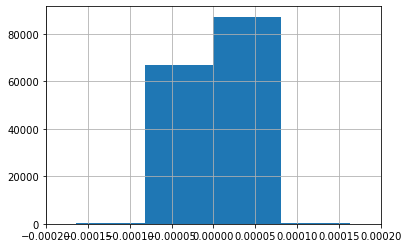

In [158]:
from matplotlib import pyplot as plt
X_new.atr_diff.hist(bins=20)
plt.xlim(-0.0002,0.0002)

# Model Training/Predicting Methods

In [5]:
def train_model(X_train, y_train, X_test, y_test, configurations, force_train=False):

    path = configurations.get('model_path', None)
    torch.manual_seed(configurations.get('random_seed',0))
    device = configurations.get('device','cpu')
    pyt_device = torch.device(device)

    model_width = (X_train.shape[1], y_train.shape[1])
    net, loss_func, optimizer, scaler, mean_losses, next_epoch, = load_model_with_config(configurations,
                                                                                         X_train,
                                                                                         model_width,
                                                                                         force_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    training_set = Dataset(X_train, y_train)
    training_generator = torch.utils.data.DataLoader(training_set, **configurations['train_params'])
    testing_set = Dataset(X_test, y_test)
    testing_generator = torch.utils.data.DataLoader(testing_set, **configurations['test_params'])
    
    to_device(net, pyt_device)
    net.train()
    print(net)

    if next_epoch == configurations['max_epochs']:
        print("Model finished training. To retrain set force_train = True ")
        net.eval()
        return net, mean_losses

    epbar = tqdm(range(next_epoch, configurations['max_epochs']))
    for epoch in epbar:
        epbar.set_description(f"Epoch {epoch+1}")

        running_eloss = 0
        running_vloss = 0

        ipbar = tqdm(training_generator, leave=False)
        ipbar.set_description(f"Training")

        for i, (x, y) in enumerate(ipbar):
            x = to_device(x, pyt_device)
            y = to_device(y, pyt_device)

            optimizer.zero_grad()
            prediction = net(x)     # input x and predict based on x
            loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            running_eloss += loss.item()

        net.eval()
        mean_vlosses = 0
        predicted_true = 0
        target_true = 0
        correct_true = 0
        
        if configurations['do_validate']:
            with torch.set_grad_enabled(False):
                vpbar = tqdm(testing_generator, leave=False)
                vpbar.set_description("Validating")
                for i, (x, y) in enumerate(vpbar):
                    x = to_device(x, pyt_device)
                    y = to_device(y, pyt_device)
                    prediction = net(x)
                    loss = loss_func(prediction, y)
                    running_vloss += loss.item()
                    
                    # calculate precision https://stackoverflow.com/questions/56643503/efficient-metrics-evaluation-in-pytorch
                    predicted_classes = torch.round(torch.sigmoid(prediction)).squeeze() #.reshape(prediction.shape[0])
                    target_classes = y.squeeze() #.reshape(y.shape[0])
                    target_true += torch.sum(target_classes == 1).float()
                    predicted_true += torch.sum(predicted_classes).float()
                    correct_true += torch.sum((predicted_classes == target_classes) * (target_classes == 1)).float()
                    
            mean_vlosses = running_vloss / len(testing_generator)
            recall = 0 if target_true==0 else float((correct_true / target_true).detach())
            precision = 0 if predicted_true==0 else float((correct_true / predicted_true).detach())
            f1_score = 0 if (precision + recall)==0 else 2 * precision * recall / (precision + recall)

        mean_elosses = running_eloss / len(training_generator)
        mean_losses.append((mean_elosses, mean_vlosses, precision, recall, f1_score))
        save_model_with_config(configurations, net=net, loss_func=loss_func, optimizer=optimizer,
                               scaler=scaler,
                               mean_losses=mean_losses, next_epoch=epoch+1,)
        net.train()

        epbar.set_postfix({'train_loss':f"{mean_elosses:.6f}", 'val_loss':f"{mean_vlosses:.6f}", 'val_prec':f"{precision:.6f}"})
    net.eval()
    
    torch.cuda.empty_cache()
    return net, mean_losses

# Load and Clean Data

In [6]:
def train_test_split(X, y, train_idx=None, test_idx=None):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]
    X_test = X.loc[test_idx]
    y_test = y.loc[test_idx]
    return (X_train, y_train, X_test, y_test)

def load_split_data(suffix=None, split=False):
    if suffix==None:
        suffix='DEFAULT'
        
    X = pd.read_pickle(f'../data/X_{suffix}.pkl')
    y = pd.read_pickle(f'../data/y_{suffix}.pkl')
    
    # Drop NA rows:
    na_rows = X.isna().any(axis=1)
    X = X[~na_rows]
    y = y[~na_rows]
        
    if split:
        X_train, y_train, X_test, y_test = train_test_split(X, y, X.loc['2018':'2020'].index, X.loc['2021':].index)
        return X_train, y_train, X_test, y_test
    else:
        return X, y
    
X_train, y_train, X_test, y_test = load_split_data(suffix='20210801f', split=True)

In [7]:
# Balance data...
add_buys = (y_train.buy==0).sum() - (y_train.buy==1).sum()

y_toadd = y_train[y_train.buy==1].sample(n=add_buys, replace=True, random_state=42)
x_toadd = X_train[y_train.buy==1].sample(n=add_buys, replace=True, random_state=42)

X_train = pd.concat([X_train,x_toadd])
y_train = pd.concat([y_train,y_toadd])

#  Model Creation

In [6]:
model_id = 'alpha10'

config = {
    'model_identifier' : model_id,
    'model_path' : './models',
    'model_type' : 'ResNet28 - Data Variant 20210801f',
    'device' : 'cuda',
    'random_seed' : 0,
    'max_epochs' : 50,
    'do_validate' : True,
    'model_width' : 10,
    'loss' : {
        'pos_weight' : 1
    },
    'optimizer' : {
        'type' : 'torch.optim.SGD',
        'lr' : 0.1,
        'weight_decay' : 0.00025,
        'momentum' : 0.9,
    },
    'train_params' : {
        'batch_size': 2000,
        'shuffle': True,
        'num_workers': 5,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 5,
        'pin_memory': True,
    },
}


model_id=config['model_identifier']
with open(f'models/{model_id}.cfg', 'w') as f:
    json.dump(config, f)

# Train

In [7]:
net, mean_losses = train_model(X_train, y_train, X_test, y_test, config, force_train=True)

New model created
ResNet28(
  (stack1): ResNetStack(
    (stack): Sequential(
      (dense_1): ResnetDenseBlock(
        (dense1): Linear(in_features=542, out_features=10, bias=True)
        (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (dense2): Linear(in_features=10, out_features=10, bias=True)
        (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dense3): Linear(in_features=10, out_features=10, bias=True)
        (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (dense_sc): Linear(in_features=542, out_features=10, bias=True)
          (bn_sc): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (identity_1a): ResnetIdentityBlock(
        (dense1): Linear(in_features=10, out_features=10, bias=True)
        (bn1): BatchNorm1d(10, eps=1e

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
torch.cuda.empty_cache()